In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from model import load_model, preprocess
import os
import torch

/Users/coco/opt/anaconda3/envs/cs1430/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
embd_full = np.load("embeddings/img_emb_0.npy")
embd_full 

array([[-0.00818 , -0.04932 , -0.0381  , ...,  0.002457, -0.03467 ,
        -0.02283 ],
       [ 0.03223 ,  0.01746 , -0.01428 , ...,  0.0199  , -0.01685 ,
         0.02686 ],
       [ 0.0349  , -0.02197 , -0.01294 , ...,  0.02649 ,  0.02124 ,
        -0.008484],
       ...,
       [-0.03394 ,  0.01361 , -0.04688 , ..., -0.006927,  0.03442 ,
        -0.00958 ],
       [-0.012695, -0.01074 ,  0.002045, ...,  0.00952 , -0.0635  ,
         0.01007 ],
       [-0.0299  ,  0.00842 ,  0.02026 , ..., -0.03027 ,  0.01349 ,
         0.0498  ]], dtype=float16)

In [8]:
image_dir = os.listdir("images")
img_index = sorted(list(map(lambda sub:int(''.join(
      [ele for ele in sub if ele.isnumeric()])), image_dir)))

In [9]:
print(embd_full.shape)
print(len(img_index))

(36125, 1024)
36125


In [10]:
indv_embd_ex = embd_full[0]
type(indv_embd_ex)

numpy.ndarray

In [11]:
from sklearn import cluster
n_clusters=500

embd_data = pd.DataFrame(embd_full)
clusters = cluster.KMeans(n_clusters).fit(embd_data)
cluster_map = pd.DataFrame()
# cluster_map['data_index'] = [img_index[i] for i in embd_data.index.values]
cluster_map['data_index'] = embd_data.index.values
cluster_map['label'] = clusters.labels_

KeyboardInterrupt: 

In [ ]:
# cluster_map.to_pickle("./full_emd.pkl")
# unpickled_df = pd.read_pickle("./full_emd.pkl")   

In [ ]:
import gradio as gr
import torch
from model import preprocess, load_model
from transformers import CLIPModel, CLIPProcessor

model = load_model("models/aesthetics_scorer_rating_openclip_vit_h_14.pth")
MODEL = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CLIPModel.from_pretrained(MODEL)
vision_model = model.vision_model
vision_model.to(DEVICE)
del model
clip_processor = CLIPProcessor.from_pretrained(MODEL)

rating_model = load_model("models/aesthetics_scorer_rating_openclip_vit_h_14.pth").to(DEVICE)
artifacts_model = load_model("models/aesthetics_scorer_artifacts_openclip_vit_h_14.pth").to(DEVICE)

def predict(img):
    inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        vision_output = vision_model(**inputs)
    pooled_output = vision_output.pooler_output
    embedding = preprocess(pooled_output)
    with torch.no_grad():
        rating = rating_model(embedding)
        artifact = artifacts_model(embedding)
    return rating.detach().cpu().item(), artifact.detach().cpu().item()


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
2023-04-19 09:18:50.710542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
cluster_pd = pd.DataFrame(columns = ["label","img_idx", "center", "rating_score", "aest_score"])
cluster_pd["label"] = list(range(n_clusters))
cluster_pd["img_idx"] = [np.array(cluster_map[cluster_map['label'] == x]["data_index"]) for x in range(n_clusters)]
cluster_pd["center"] = list(clusters.cluster_centers_)                                          

NameError: name 'cluster_map' is not defined

In [13]:
cluster_pd

label img_idx center rating_score aest_score
0        0     NaN    NaN          NaN        NaN
1        1     NaN    NaN          NaN        NaN
2        2     NaN    NaN          NaN        NaN
3        3     NaN    NaN          NaN        NaN
4        4     NaN    NaN          NaN        NaN
..     ...     ...    ...          ...        ...
495    495     NaN    NaN          NaN        NaN
496    496     NaN    NaN          NaN        NaN
497    497     NaN    NaN          NaN        NaN
498    498     NaN    NaN          NaN        NaN
499    499     NaN    NaN          NaN        NaN

[500 rows x 5 columns]

In [14]:
curr_embd = 1
cluster_pd_pickle = pd.read_pickle("./full_emd_score" + str(curr_embd) + ".pkl")   
cluster_pd_pickle

FileNotFoundError: [Errno 2] No such file or directory: './full_emd_score1.pkl'

In [15]:
# cluster_pd = pd.read_pickle("./full_emd_score" + str(curr_embd) + ".pkl")   
for idx in range(curr_embd + 1, 500): 
    print("current cluster: " + str(idx))
    curr_clus_img_list = cluster_pd_pickle["img_idx"][idx]
    print(len(curr_clus_img_list))
    clus_rating_score = 0 #high is good
    clus_artif_score = 0 #low is good 
    for curr_img_idx in curr_clus_img_list: 
        img_path = "images/" + image_dir[curr_img_idx]
        clus_pred = predict(plt.imread(img_path))
        clus_rating_score += int(clus_pred[0])
        clus_artif_score += int(clus_pred[1])
    cluster_pd_pickle.loc[idx,"rating_score"] = clus_rating_score / len(curr_clus_img_list)
    cluster_pd_pickle.loc[idx,"aest_score"] = clus_artif_score / len(curr_clus_img_list)
    cluster_pd_pickle.to_pickle("./full_emd_score" + str(idx) + ".pkl")
    

current cluster: 2


NameError: name 'cluster_pd_pickle' is not defined

In [16]:
pd.read_pickle("./full_emd_score0.pkl")   

FileNotFoundError: [Errno 2] No such file or directory: './full_emd_score0.pkl'

In [17]:
cluster_pd_pickle = pd.read_pickle("./full_emd_score" + str(499) + ".pkl")   

In [28]:
import math
from matplotlib import gridspec

def subplot_cluster(cluster_pd, img_plt_idx):
    img_idx_list = cluster_pd["img_idx"][img_plt_idx]
    N = len(img_idx_list)
    cols = 3
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    fig.suptitle("cluster " + str(img_plt_idx) + " with rating of " +  str(cluster_pd["rating_score"][img_plt_idx]))
    for n in range(N):
        img_path = "images/" + image_dir[img_idx_list[n]]
        ax = fig.add_subplot(gs[n])
        ax.imshow(plt.imread(img_path))
    fig.tight_layout()
    

/var/folders/c7/fxjchd_151bd358smv7fbm640000gn/T/ipykernel_59581/1728922331.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


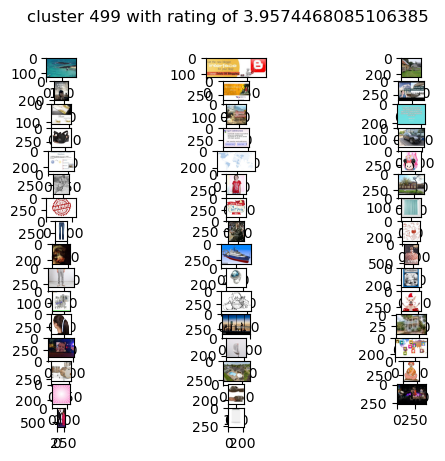

In [29]:
subplot_cluster(cluster_pd_pickle, 499)

In [20]:
cluster_pd_pickle

label                                            img_idx   
0        0  [1717, 4165, 5567, 6884, 8560, 8817, 9069, 124...  \
1        1  [92, 432, 679, 2719, 5136, 6075, 6146, 6577, 7...   
2        2  [109, 144, 478, 564, 585, 1908, 2095, 2264, 25...   
3        3  [162, 1659, 1920, 2168, 3978, 4128, 4674, 5261...   
4        4  [21, 1127, 1260, 1986, 2041, 2993, 4338, 4720,...   
..     ...                                                ...   
495    495  [85, 342, 666, 673, 1063, 1256, 1466, 1616, 20...   
496    496  [618, 644, 2624, 2842, 3149, 3246, 3272, 3366,...   
497    497  [413, 5600, 8727, 9223, 11153, 13220, 15624, 1...   
498    498  [2118, 3268, 3347, 3870, 4220, 4274, 6303, 704...   
499    499  [266, 351, 596, 946, 1593, 1943, 1949, 3321, 4...   

                                                center rating_score aest_score  
0    [-0.0069408416748046875, -0.001300811767578123...     4.083333   2.208333  
1    [-0.0007424965882912677, 0.012880912193885222,...     3.987179   2.538462  
2    [0.006140124413274948, -0.013523963189894152, ...     3.693548    2.66129  
3    [0.001089027949741906, 0.002168655395507814, 0...          4.0   2.428571  
4    [-0.016064270682956863, 0.007230122884114586, ...          4.0   2.376812  
..                                                 ...          ...        ...  
495  [-0.0006895798903245208, -0.005415633702889466...     4.012821   2.410256  
496  [0.007192054352202972, 0.006923328746448866, 0...      3.87013   2.454545  
497  [0.011936823527018223, 0.00568249821662903, 0....     3.958333   2.291667  
498  [-0.0007574898856026789, -0.00705329739317602,...     4.183673   2.285714  
499  [-0.0020805521214261966, 0.008404670877659575,...     3.957447   2.404255  

[500 rows x 5 columns]

Text(0, 0.5, 'count of clusters')

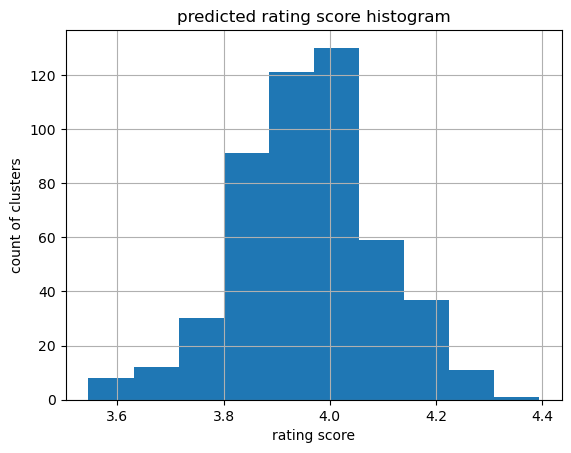

In [21]:
plt.subplot(1,1,1)
rating_hist = cluster_pd_pickle["rating_score"].hist(bins = 10)
plt.title("predicted rating score histogram")
plt.xlabel("rating score")
plt.ylabel("count of clusters")


Text(0.5, 1.0, 'predicted aesthetic score histogram')

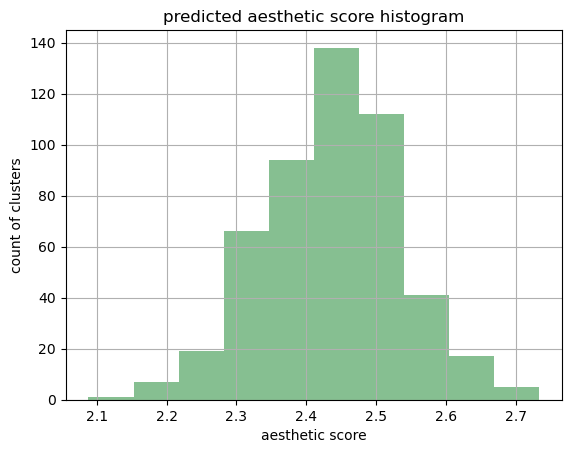

In [22]:
plt.subplot(1,1,1)
aest_hist = cluster_pd_pickle["aest_score"].hist(bins = 10, color='#86bf91')
plt.xlabel("aesthetic score")
plt.ylabel("count of clusters")
plt.title("predicted aesthetic score histogram")

In [23]:
sorted_clusters = cluster_pd_pickle.sort_values('aest_score')

In [24]:
sorted_clusters

label                                            img_idx   
11      11  [95, 696, 1653, 2739, 6115, 7389, 7425, 7515, ...  \
449    449  [661, 1959, 2554, 3202, 8644, 11560, 13052, 14...   
234    234  [291, 622, 655, 1042, 2031, 2578, 3801, 3975, ...   
345    345  [250, 1090, 1314, 2106, 3590, 4131, 4759, 4792...   
125    125  [1866, 2266, 3069, 7348, 7890, 7987, 11365, 14...   
..     ...                                                ...   
175    175  [1072, 1656, 2054, 2205, 3395, 3623, 4174, 553...   
200    200  [26, 5819, 6906, 6915, 7951, 8071, 8178, 13047...   
118    118  [703, 958, 3323, 3690, 4136, 4924, 6209, 6937,...   
316    316  [1689, 2099, 3997, 5207, 5986, 7245, 9196, 962...   
446    446  [452, 2094, 11761, 14087, 14509, 15706, 19437,...   

                                                center rating_score aest_score  
11   [0.006591572481043196, 0.0007945790010340076, ...     4.147059   2.088235  
449  [0.0029645647321428553, 0.003174550192696707, ...          4.2   2.171429  
234  [0.00987149121468527, 0.02500687983998081, -0....     4.157895   2.192982  
345  [-0.005502390307049419, -0.00566871776137241, ...     4.209302   2.197674  
125  [-0.019156901041666667, -0.020041910807291664,...     4.066667        2.2  
..                                                 ...          ...        ...  
175  [0.0052768985430399545, -0.005356947580973308,...     3.854167     2.6875  
200  [0.0413330078125, -0.011199188232421874, 0.001...         3.75        2.7  
118  [-0.007727813720703126, 0.005402493476867675, ...         3.55        2.7  
316  [-0.02322836483226103, -0.009333666633157168, ...     3.588235   2.705882  
446  [0.00744679768880208, -0.00809326171875, -0.01...     3.666667   2.733333  

[500 rows x 5 columns]

In [41]:
import matplotlib.image as mpimg

def plot_cluster(cluster_pd, img_plt_idx):
    img_idx_list = cluster_pd["img_idx"][img_plt_idx]
    N = len(img_idx_list)

    fig = plt.figure()
    fig.suptitle("cluster " + str(img_plt_idx) + " with rating of " +  str(cluster_pd["rating_score"][img_plt_idx]))
    for n in range(N):
        print(image_dir[img_idx_list[n]])
        img_path = "images/" + image_dir[img_idx_list[n]]
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.show()
        # ax = fig.add_subplot(rows, cols, n+1)
        # ax.imshow(plt.imread(img_path))
        # plt.pause(0.01)
        # plt.draw()
    # fig.tight_layout()

photo_24049.jpg


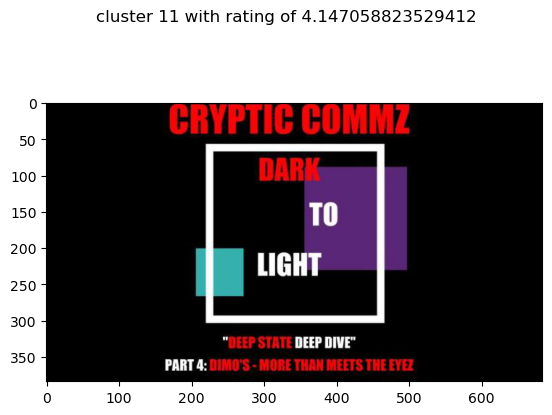

photo_25753.jpg


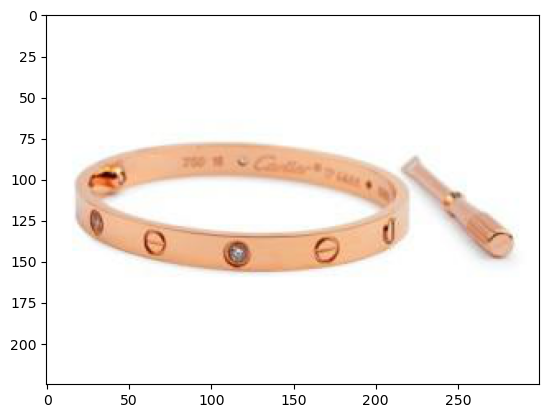

photo_5963.jpg


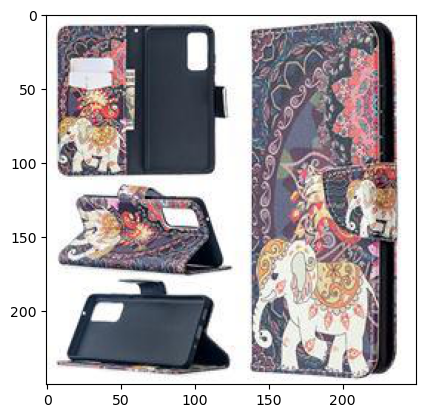

photo_19644.jpg


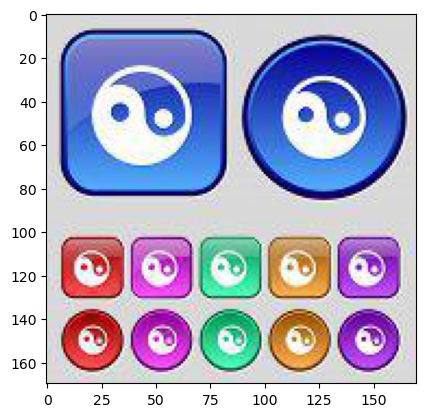

photo_37422.jpg


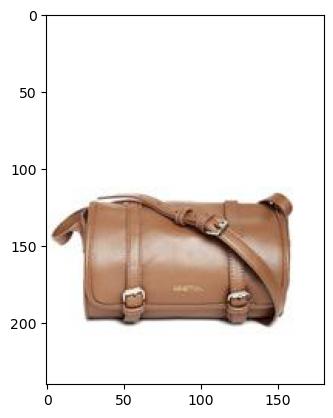

photo_34673.jpg


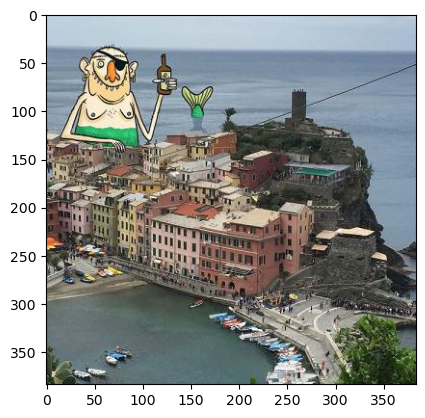

photo_111.jpg


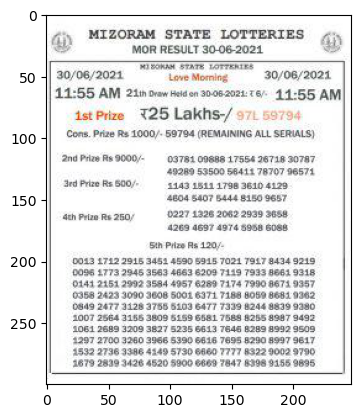

photo_14548.jpg


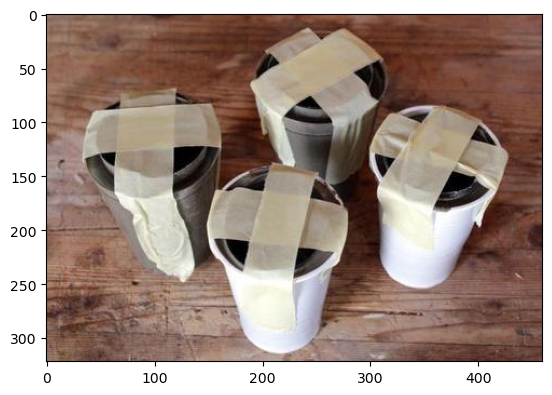

photo_25597.jpg


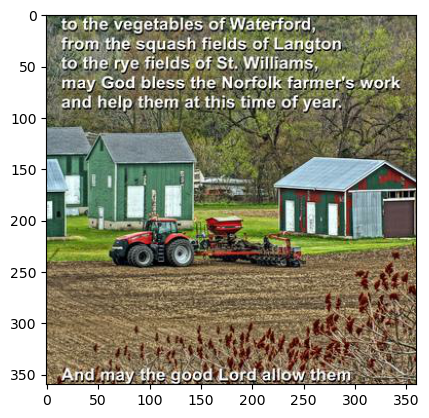

photo_3442.jpg


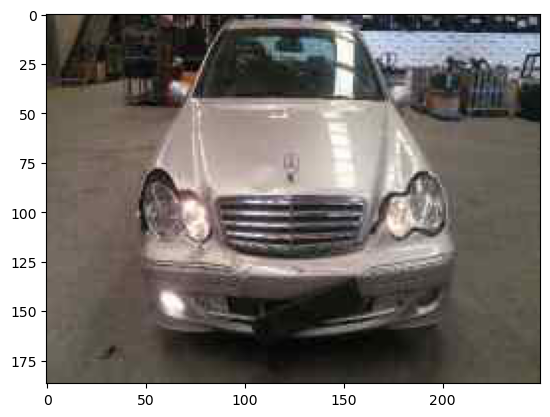

photo_25019.jpg


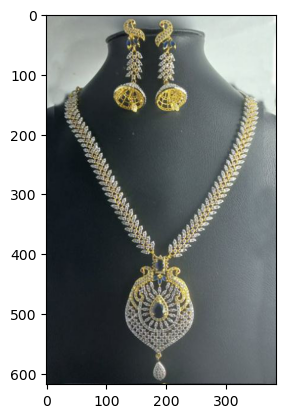

photo_26749.jpg


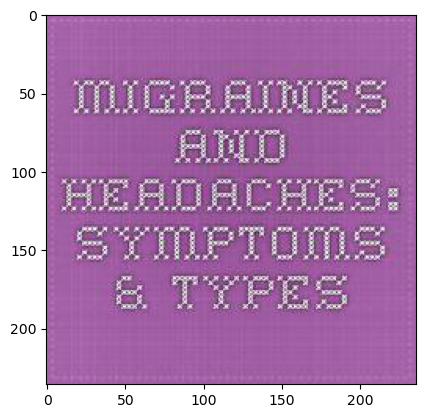

photo_5294.jpg


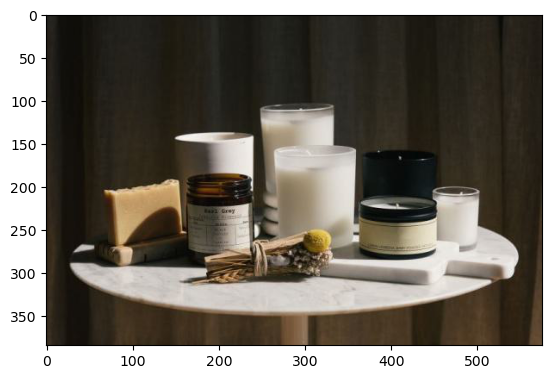

photo_6211.jpg


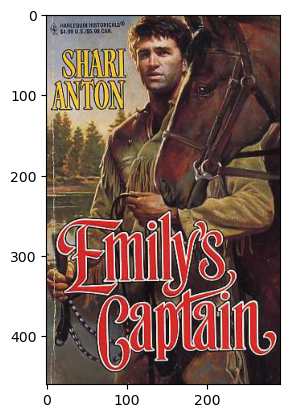

photo_31747.jpg


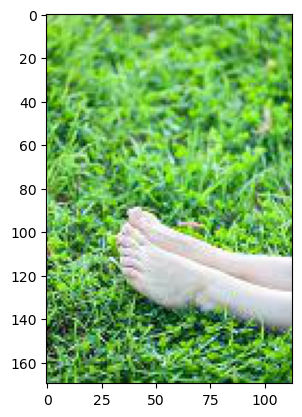

photo_37040.jpg


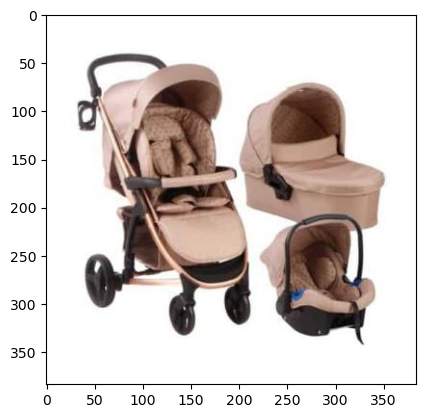

photo_6349.jpg


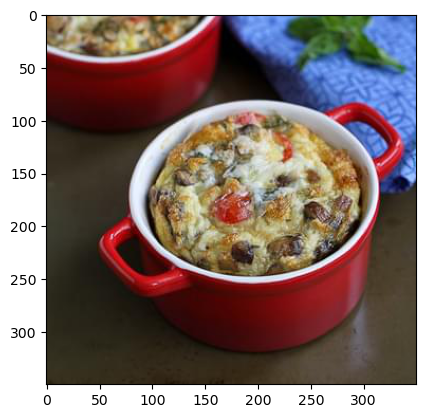

photo_7731.jpg


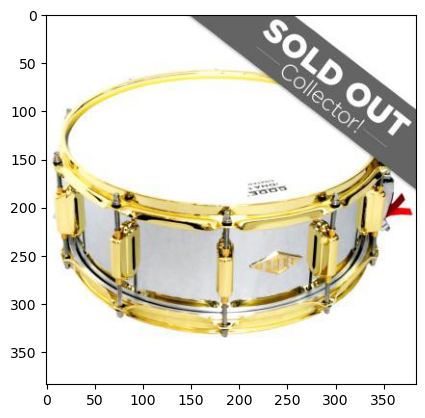

photo_30852.jpg


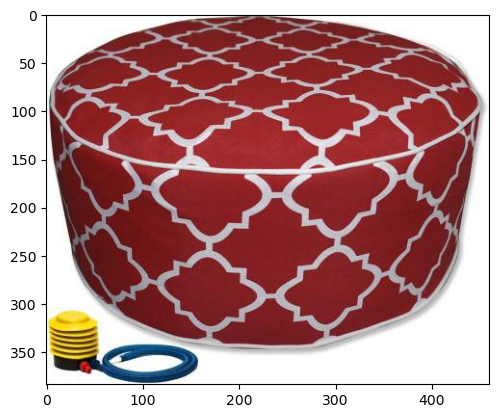

photo_27489.jpg


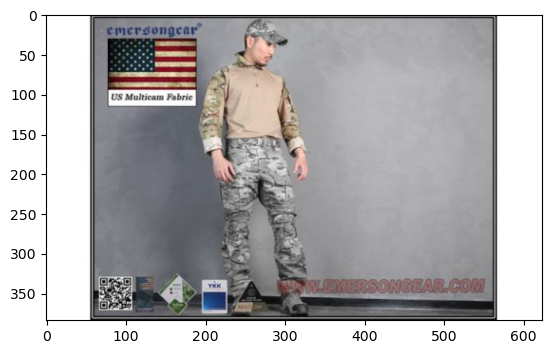

photo_15835.jpg


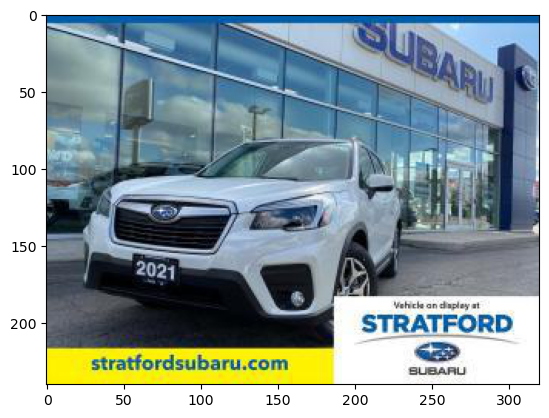

photo_16468.jpg


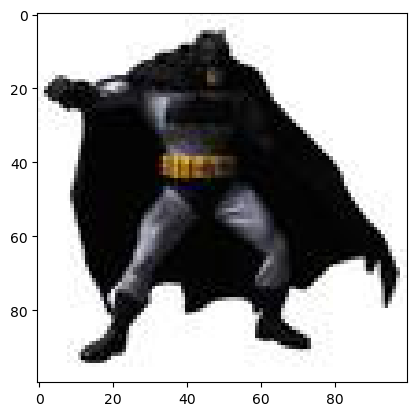

photo_4580.jpg


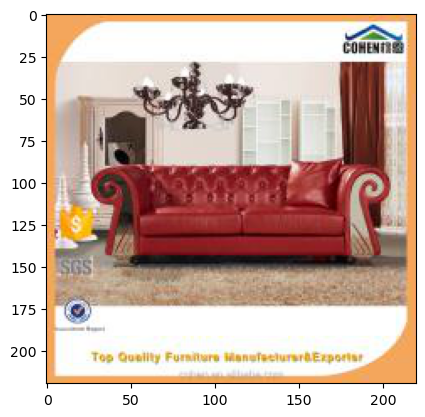

photo_8556.jpg


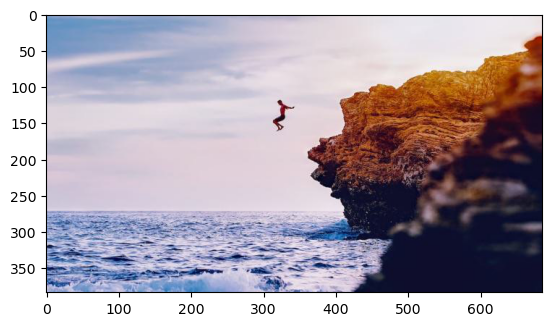

photo_11060.jpg


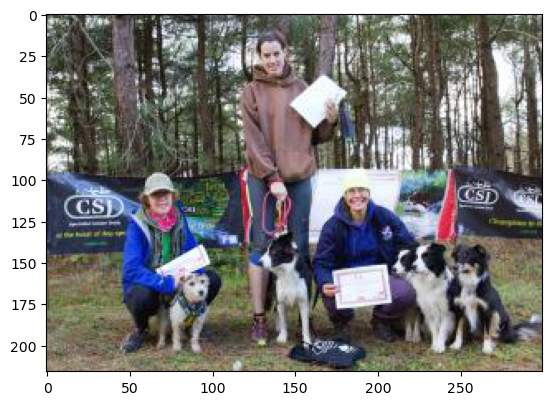

photo_36378.jpg


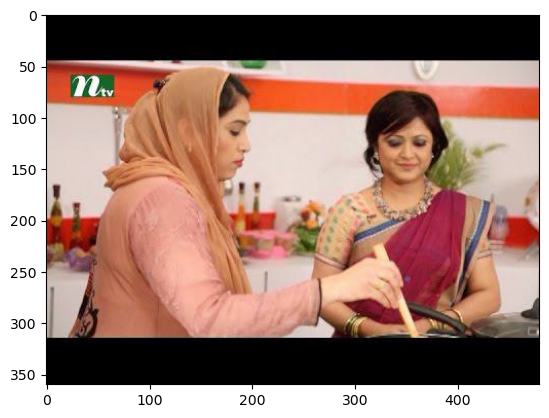

photo_34180.jpg


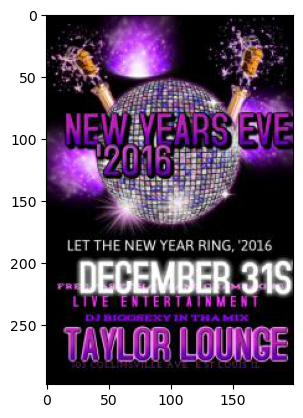

photo_19563.jpg


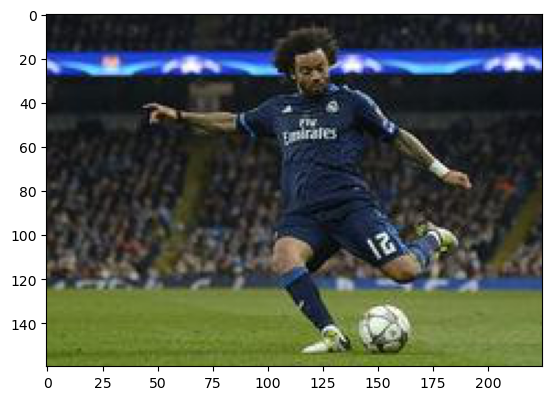

photo_2454.jpg


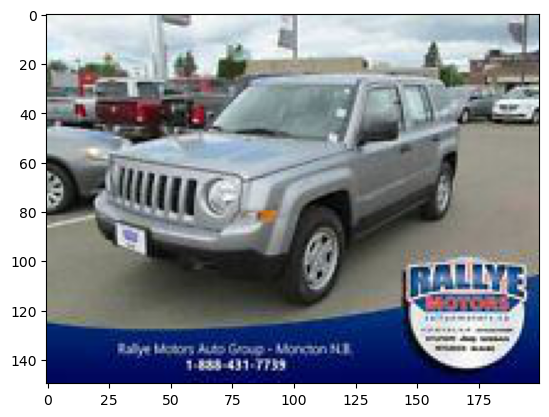

photo_11414.jpg


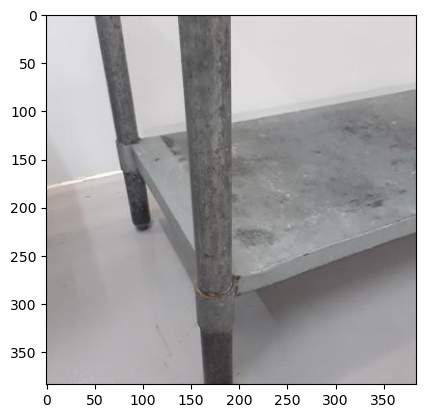

photo_38326.jpg


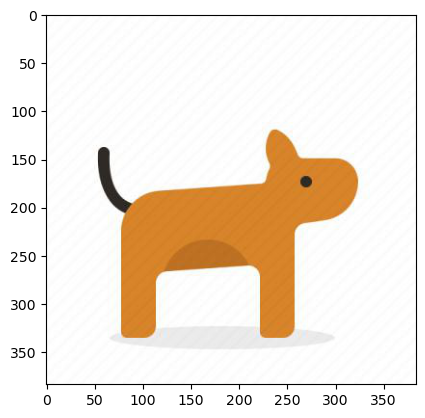

photo_7010.jpg


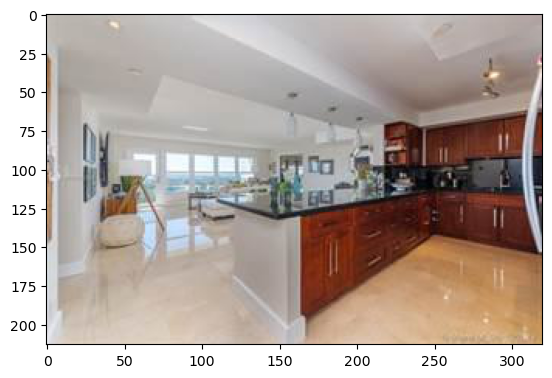

photo_11772.jpg


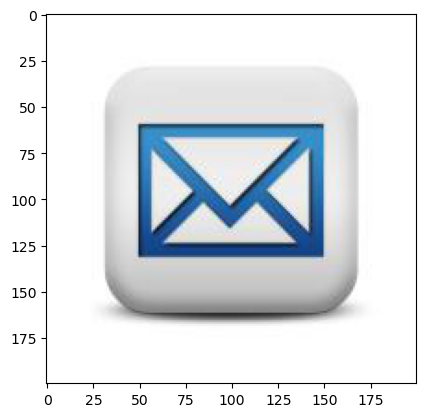

photo_35175.jpg


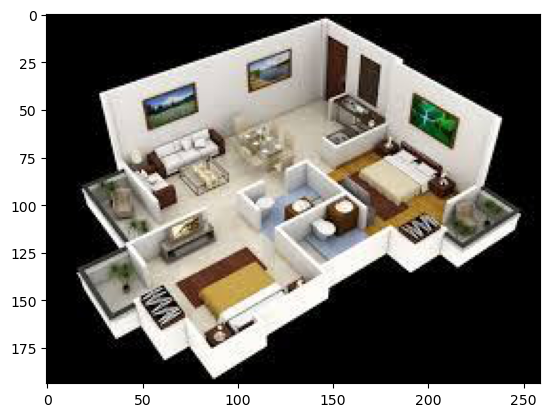

In [42]:
plot_cluster(cluster_pd_pickle, 11)